In [348]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pingouin as pg
import scikit_posthocs as sp
import warnings
warnings.filterwarnings("ignore")

sns.set(rc={'figure.figsize': (18, 6)})

## Предварительный анализ данных

In [287]:
# Считываем данные и сразу переводим колонку со временем в формат даты
london = pd.read_csv('london.csv', parse_dates=['timestamp'])

In [288]:
london.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [289]:
# Количество строк и столбцов
london.shape

(17414, 10)

In [290]:
# Проверяем данные на пропуски
london.isnull().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

In [291]:
# Проверяем типы данных
london.dtypes

timestamp       datetime64[ns]
cnt                      int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code           float64
is_holiday             float64
is_weekend             float64
season                 float64
dtype: object

In [292]:
# Смотрим описательные статистики
london.describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
mean,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075
std,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911
min,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000
50%,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000
75%,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000
max,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000


<Axes: xlabel='timestamp', ylabel='cnt'>

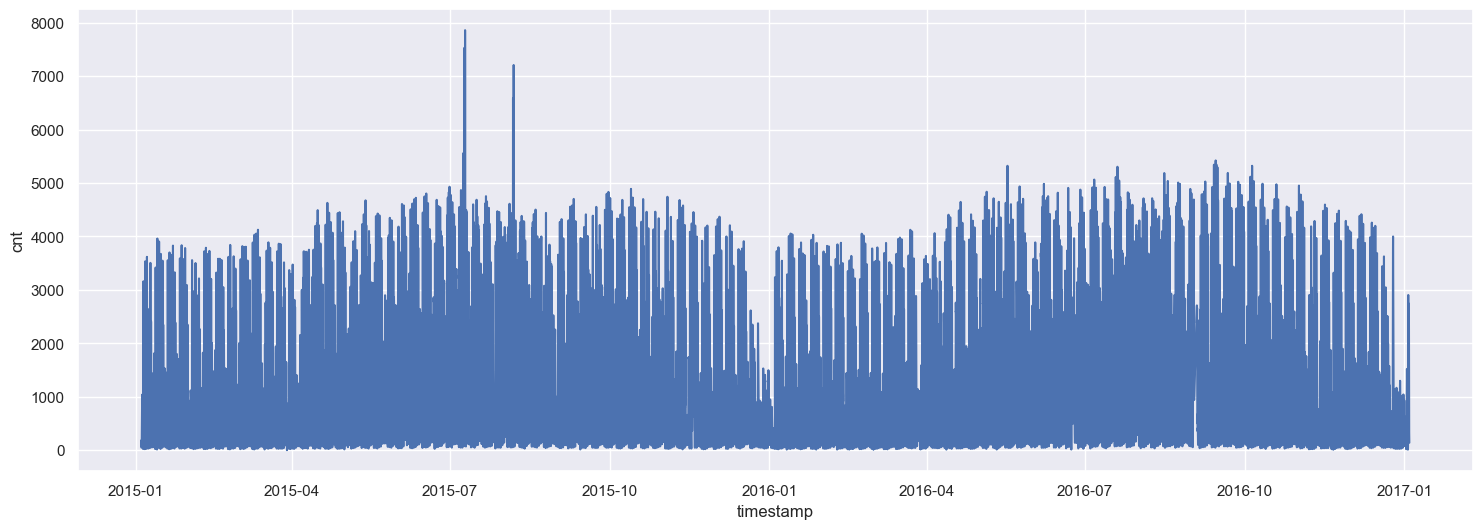

In [293]:
# Визуализируем число поездок по датам 
sns.lineplot(x='timestamp', y='cnt', data=london)

In [349]:
# Данные в колонке timestamp разбиты по часам, сделаем преобразование
london = london.set_index('timestamp', drop=False)
london_resample = london.resample('D').cnt.sum().to_frame()

<Axes: xlabel='timestamp', ylabel='cnt'>

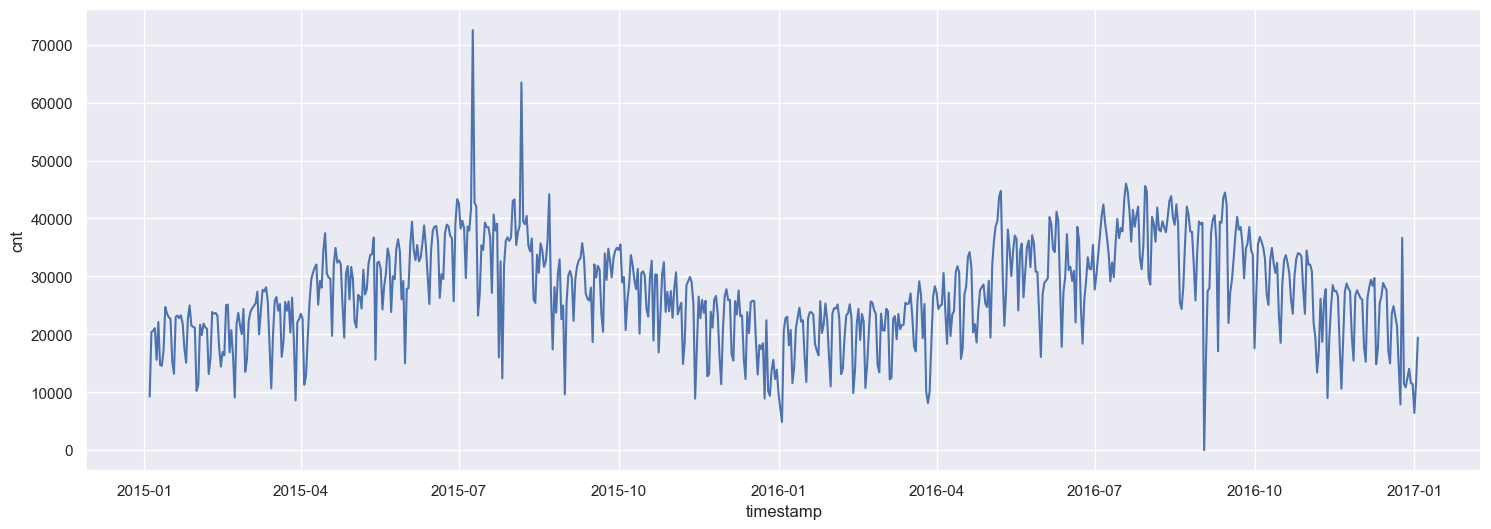

In [350]:
# Посмотрим на распределение числа поездок по дням
sns.lineplot(x='timestamp', y='cnt', data=london_resample)

На графике присутствуют скачки. Чтобы определить, в какие дни они произошли построим доверительный интервал - всё, что выходит за его пределы, будет считаться аномалией. Для построения доверительного интервала будем использовать скользящее среднее.

In [351]:
# Посчитаем скользящее среднее
london_resample['cnt_avg_mean'] = london_resample.cnt.rolling(window=3).mean()

In [352]:
london_resample.head()

,cnt,cnt_avg_mean
timestamp,,
2015-01-04,9234,NaN
2015-01-05,20372,NaN
2015-01-06,20613,16739.666667
2015-01-07,21064,20683.000000
2015-01-08,15601,19092.666667


In [353]:
# Посчитаем разницу между скользящими средними и реальными значениями
london_resample['dif'] = london_resample.cnt - london_resample.cnt_avg_mean

In [354]:
# Найдём стандартное отклонение
std = np.std(london_resample.dif)

In [355]:
# Определим границы 99% доверительного интервала.
london_resample['upper_bound'] = london_resample.cnt_avg_mean + 2.576 * std
london_resample['lower_bound'] = london_resample.cnt_avg_mean - 2.576 * std

In [356]:
london_resample.head()

,cnt,cnt_avg_mean,dif,upper_bound,lower_bound
timestamp,,,,,
2015-01-04,9234,NaN,NaN,NaN,NaN
2015-01-05,20372,NaN,NaN,NaN,NaN
2015-01-06,20613,16739.666667,3873.333333,28482.585854,4996.747479
2015-01-07,21064,20683.000000,381.000000,32425.919188,8940.080812
2015-01-08,15601,19092.666667,-3491.666667,30835.585854,7349.747479


In [357]:
# Отфильтруем наблюдения, для которых значения оказались выше границы 99% доверительного интервала.
london_resample[london_resample.cnt > london_resample.upper_bound]

,cnt,cnt_avg_mean,dif,upper_bound,lower_bound
timestamp,,,,,
2015-07-09,72504,50705.000000,21799.000000,62447.919188,38962.080812
2015-08-06,63468,46627.333333,16840.666667,58370.252521,34884.414146
2016-09-04,27512,14259.000000,13253.000000,26001.919188,2516.080812
2016-12-25,36653,19650.666667,17002.333333,31393.585854,7907.747479


In [358]:
# Самое высокое значение числа аренд 09.07.2015 года связано с забастовками работников метрополитена

In [359]:
# Отфильтруем наблюдения, для которых значения оказались ниже границы 99% доверительного интервала.
london_resample[london_resample.cnt < london_resample.lower_bound]

,cnt,cnt_avg_mean,dif,upper_bound,lower_bound
timestamp,,,,,
2015-05-14,15609,28709.333333,-13100.333333,40452.252521,16966.414146
2015-07-12,23240,36036.666667,-12796.666667,47779.585854,24293.747479
2015-07-24,16034,31013.666667,-14979.666667,42756.585854,19270.747479
2015-08-24,17400,29529.333333,-12129.333333,41272.252521,17786.414146
2015-11-14,8898,21037.333333,-12139.333333,32780.252521,9294.414146
2016-09-02,0,26086.333333,-26086.333333,37829.252521,14343.414146
2016-09-10,17080,31262.000000,-14182.000000,43004.919188,19519.080812
2016-09-16,21967,36193.333333,-14226.333333,47936.252521,24450.414146
2016-11-12,8990,20878.000000,-11888.000000,32620.919188,9135.080812


В полученных данных выявлены скачки числа аренд. Чтобы определить дни с аномальными значениями, построен доверительный интервал для скользящего среднего. Самое высокое значение числа аренд было 09.07.2015, что связано с забастовками работников метро. Самое низкое число аренд 02.09.2015 (равно 0) может быть связано с ошибкой ввода данных.

### Количество аренд в зависимости от праздничных и выходных дней

In [360]:
# Посмотрим на число аренд в зависимости от того является ли день праздничным
# В данных явно укажем является ли день празником
london['is_holiday'] = london['is_holiday'].astype('str')
london['is_holiday']= london.is_holiday.str.replace('1.0', 'holiday').str.replace('0.0', 'not holiday')

In [307]:
# Сгруппируем данные и посмотрим количество аренд по праздникам и обычным дням
london_holiday = london.groupby('is_holiday').agg({'cnt':'sum'}).reset_index()

<Axes: xlabel='is_holiday', ylabel='cnt'>

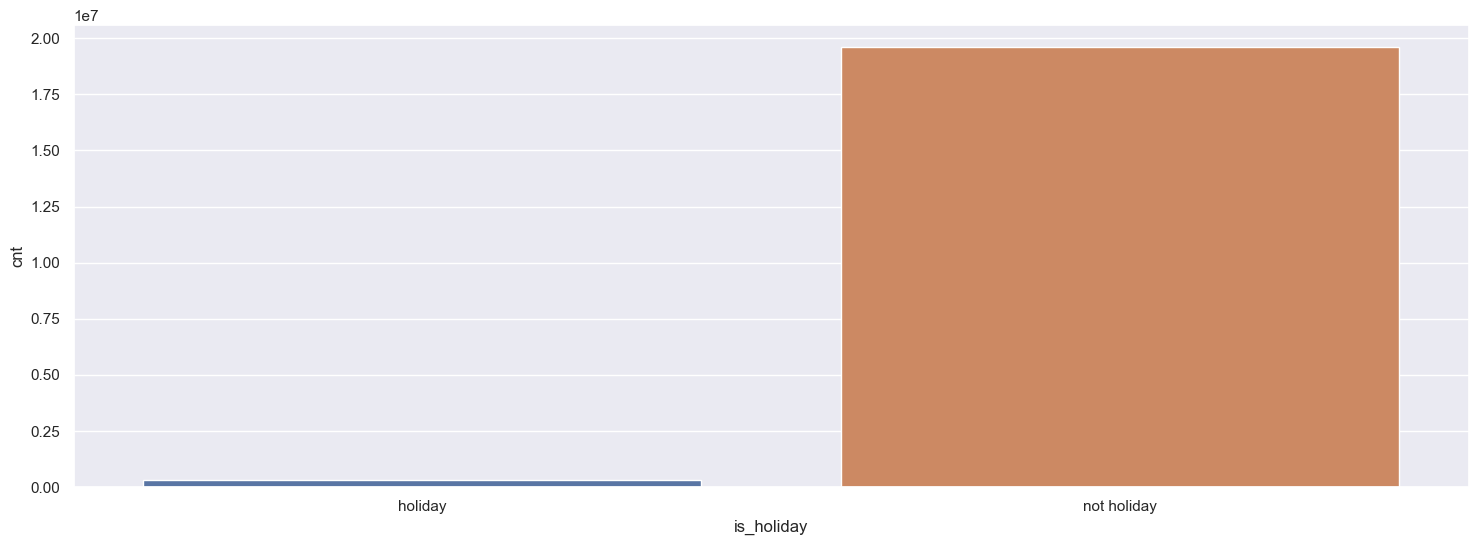

In [361]:
# Визуализируем
sns.barplot(x='is_holiday', y='cnt', data=london_holiday)

In [309]:
# Посмотрим на число аренд в зависимости от рабочих и выходных дней
# В колонке isweekend указано  является ли день выходным (1 – выходной, 0 – нет)
london['is_weekend'] = london['is_weekend'].astype('str')
london['is_weekend']= london.is_weekend.str.replace('1.0', 'weekend').str.replace('0.0', 'workday')

In [362]:
# Сгруппируем данные и посмотрим количество аренд по выходным и рабочим дням
london_weekend = london.groupby('is_weekend').agg({'cnt':'sum'}).reset_index()

<Axes: xlabel='is_weekend', ylabel='cnt'>

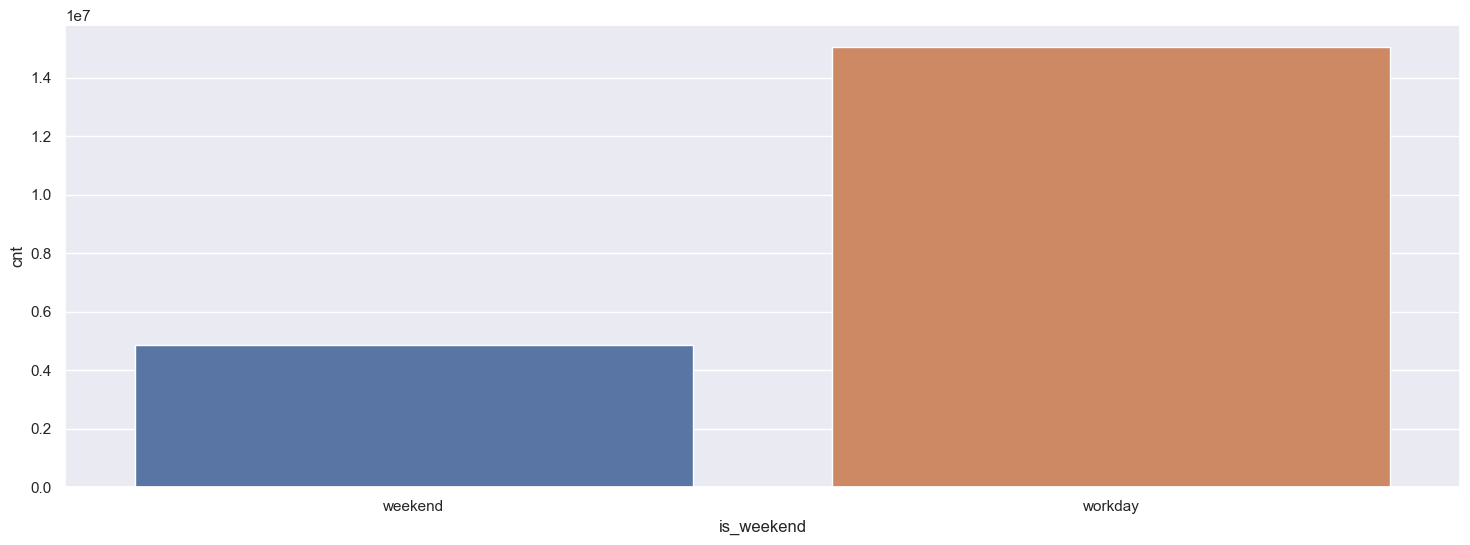

In [363]:
# Визуализируем
sns.barplot(x='is_weekend', y='cnt', data=london_weekend)

В праздники число аренд очень мало по сравнению с обычными днями. Число аренд по рабочим дням в 3 раза выше, чем в выходные.

### Количество аренд в зависимости от сезона

In [312]:
# В колонке season зашифрован метеорологический сезон (0 – весна, 1 – лето, 2 – осень, 3 – зима) 
# Напишем функцию для явного определения принадлежности к сезону.
def season(x):
    if x == 0.0:
        return 'spring'
    elif x == 1.0:
        return 'summer'
    elif x == 2.0:
        return 'autumn'
    elif x == 3.0:
        return 'winter'

In [313]:
london['season'] = london.season.apply(season)

In [364]:
# Сгруппируем данные по сезонам и посчитаем количество аренд
london_season = london.groupby('season').agg({'cnt':'sum'}).reset_index()

<Axes: xlabel='season', ylabel='cnt'>

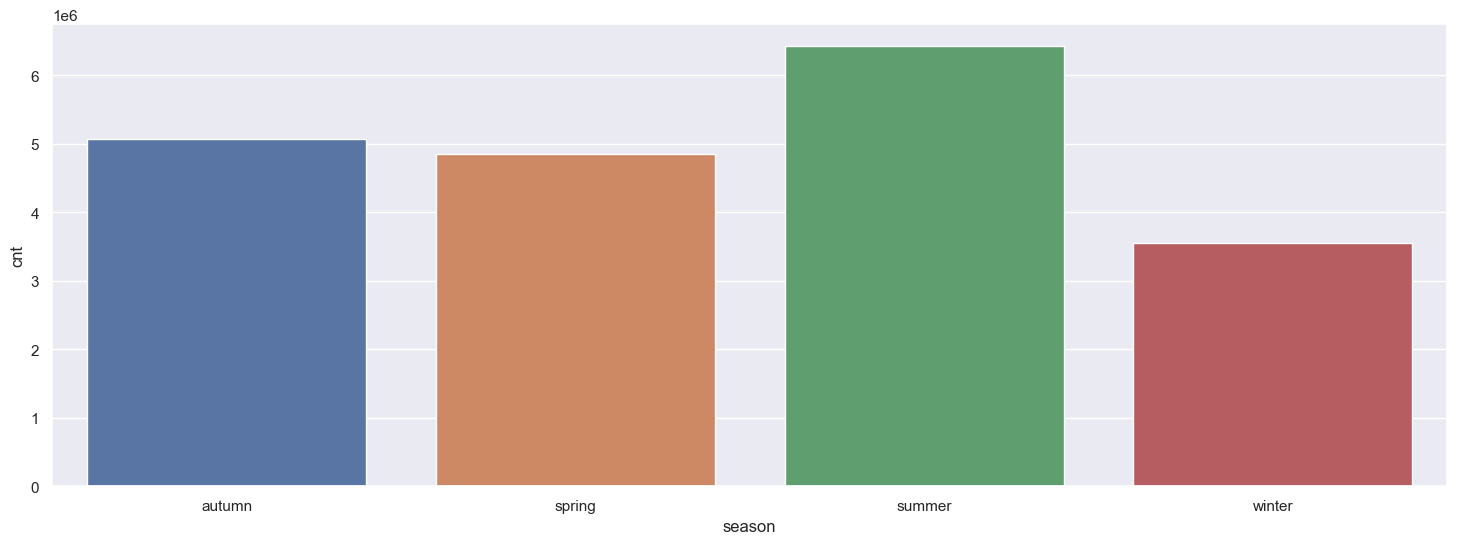

In [365]:
# Посмотрим на распределение количества аренд по сезонам
sns.barplot(x='season', y='cnt', data=london_season)

In [366]:
# По диаграмме видно, что число аренд зимой и летом различаются почти в два раза.
# Между весной и осенью есть небольшие различия. Можно проверить статистически значимы они или нет.

In [367]:
# Проверим распределения аренд по сезонам на нормальность 
pg.normality(data=london, dv='cnt', group='season', method='normaltest')

,W,pval,normal
season,,,
winter,1311.149359,1.938806e-285,False
spring,771.059409,3.686181e-168,False
summer,549.131087,5.723998e-120,False
autumn,898.659957,7.218881e-196,False


In [318]:
# Поскольку распределения отличаются от нормальных, используем непараметрический аналог ANOVA критерий Краскела-Уоллиса
pg.kruskal(data=london, dv='cnt', between='season')

,Source,ddof1,H,p-unc
Kruskal,season,3,669.766599,7.543621e-145


In [368]:
# В группах найдены статистически значимые различия. Посмотрим в каких именно.
sp.posthoc_dunn(a=london, val_col='cnt', group_col='season', p_adjust='holm')
# Все группы отличаются друг от друга.

,autumn,spring,summer,winter
autumn,1.000000e+00,5.168629e-04,4.114975e-26,1.255364e-49
spring,5.168629e-04,1.000000e+00,4.916235e-45,3.178131e-30
summer,4.114975e-26,4.916235e-45,1.000000e+00,3.140979e-144
winter,1.255364e-49,3.178131e-30,3.140979e-144,1.000000e+00


Число аренд различается по сезонам.

### Количество аренд в зависимости от погодных условий

In [320]:
# В колонке weather_code зашифрованы погодные условия. 
# Чтобы с этой колонкой было удобнее работать, явно укажем погодные условия.
def weather_code(x):
    if x == 1.0:
        return 'ясно'
    elif x == 2.0:
        return 'преимущественно ясно'
    elif x == 3.0:
        return 'облачно'
    elif x == 4.0:
        return 'пасмурно'
    elif x == 7.0:
        return 'небольшой дождь'
    elif x == 10.0:
        return 'дождь с грозой'
    elif x == 26.0:
        return 'снегопад'
    elif x == 94.0:
        return 'ледяной туман'

In [321]:
london['weather_code'] = london.weather_code.apply(weather_code)

<Axes: xlabel='weather_code', ylabel='cnt'>

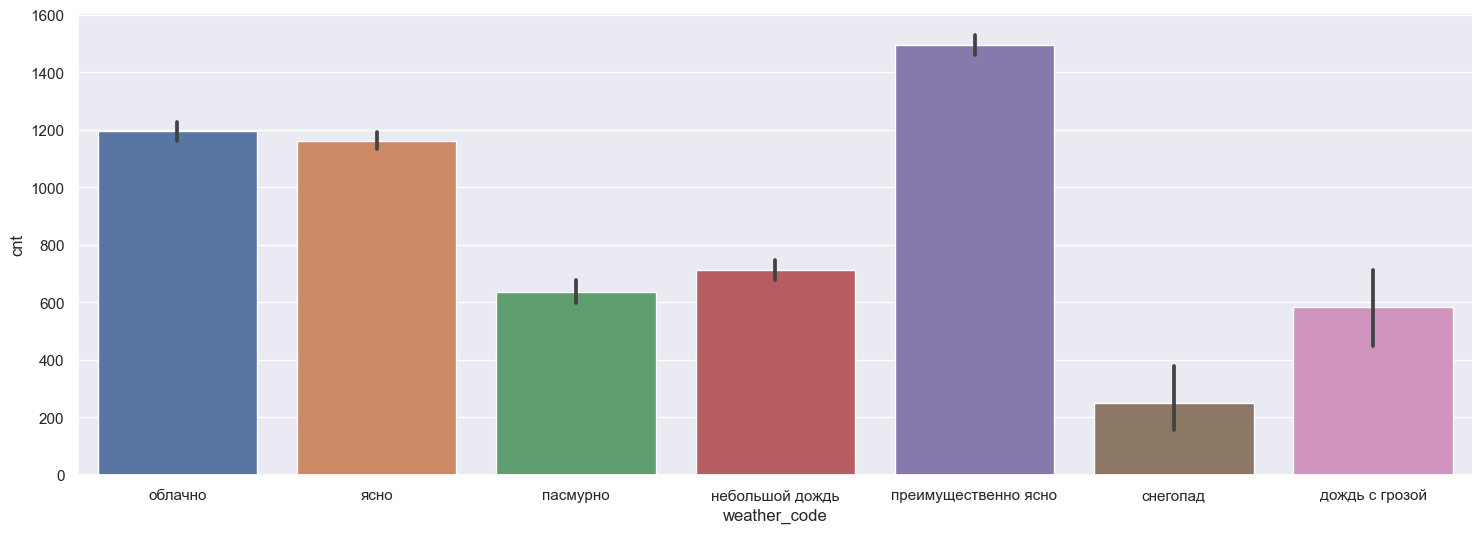

In [322]:
# Распределение числа аренд в зависимости от погодных условий
sns.barplot(x='weather_code', y='cnt', data=london)

Количество аренд больше всего в ясную погоду, меньше всего в снегопад и дождь.

### Количество аренд в зависимости от дней недели.

In [323]:
# Вытаскиваем из даты номер дня недели. Данная информация понадобится для анализа аренд по дням недели.
london['day_name'] = london.timestamp.dt.day_name()

<Axes: xlabel='day_name', ylabel='cnt'>

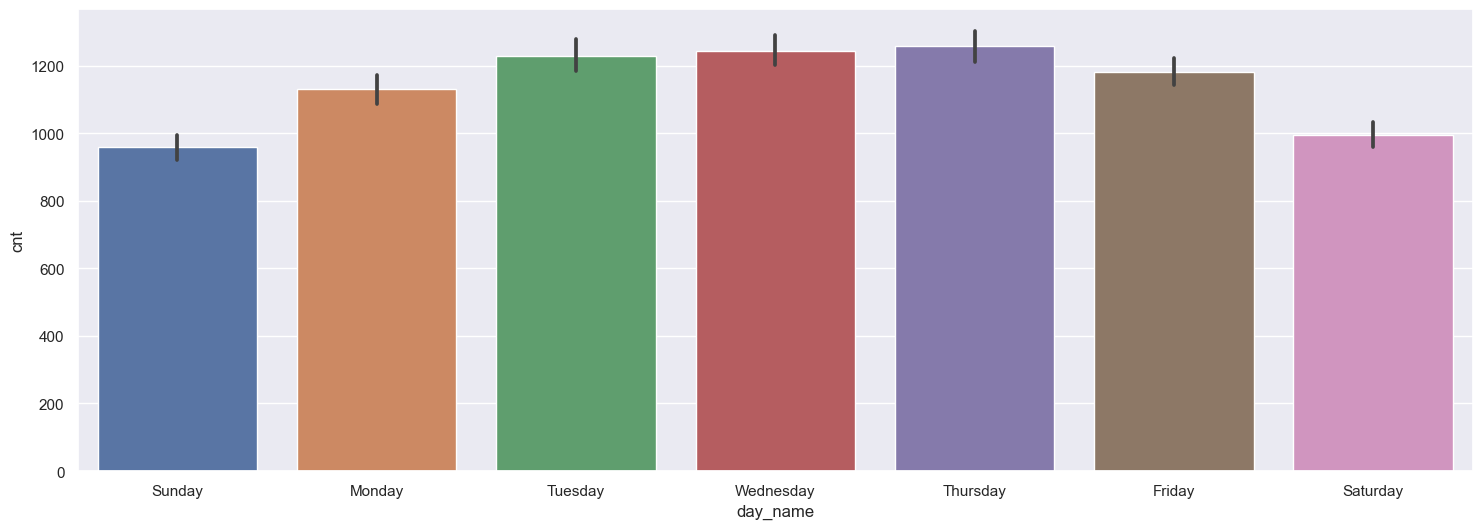

In [324]:
# Распределение числа аренд по дням недели
sns.barplot(x='day_name', y='cnt', data=london)

In [369]:
# По графику видно, что число аренд в выходные меньше, чем в будние дни. 
# Число аренд в понедельник визуально меньше, чем в другие дни.
# Чтобы привлечь клиентов, можно в определеённые дни сделать скидки или какие-нибудь специальные условия.
# Чтобы определить дни для скидок, нужно определить статистически значимые различия в числе аренд по дням.
# Сравнить рабочие и выходные дни между собой. Потом определить по каким дням устраивать скидки и давать спец.условия.

<Axes: xlabel='day_name', ylabel='cnt'>

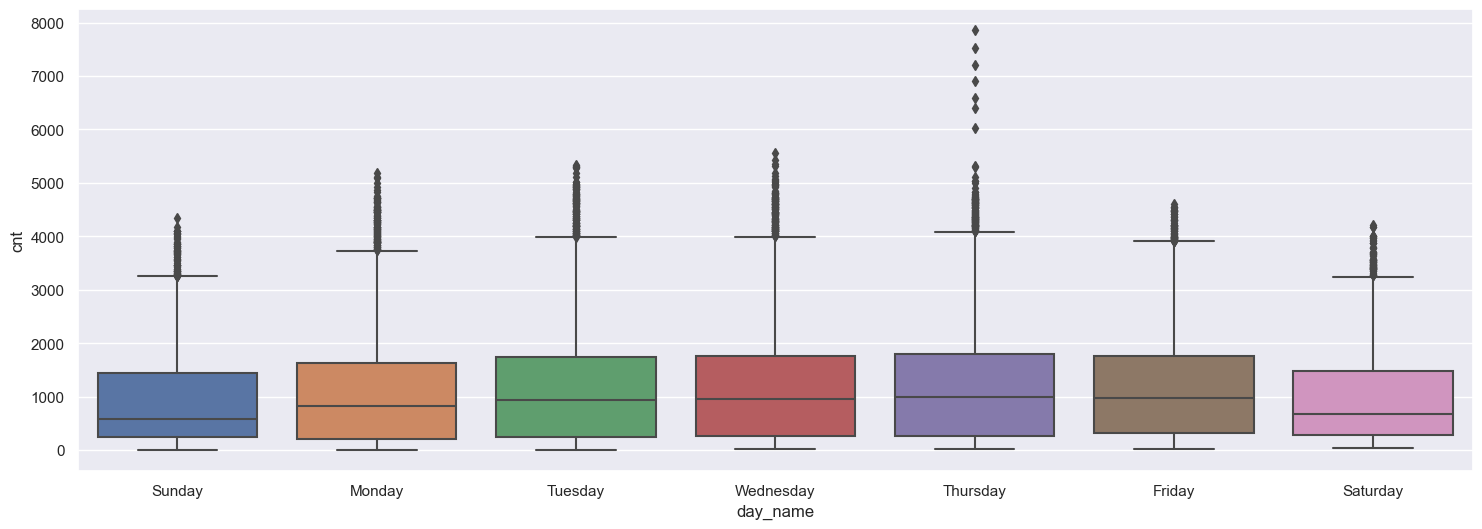

In [370]:
sns.boxplot(data=london, x='day_name', y='cnt')

<Axes: xlabel='day_name', ylabel='cnt'>

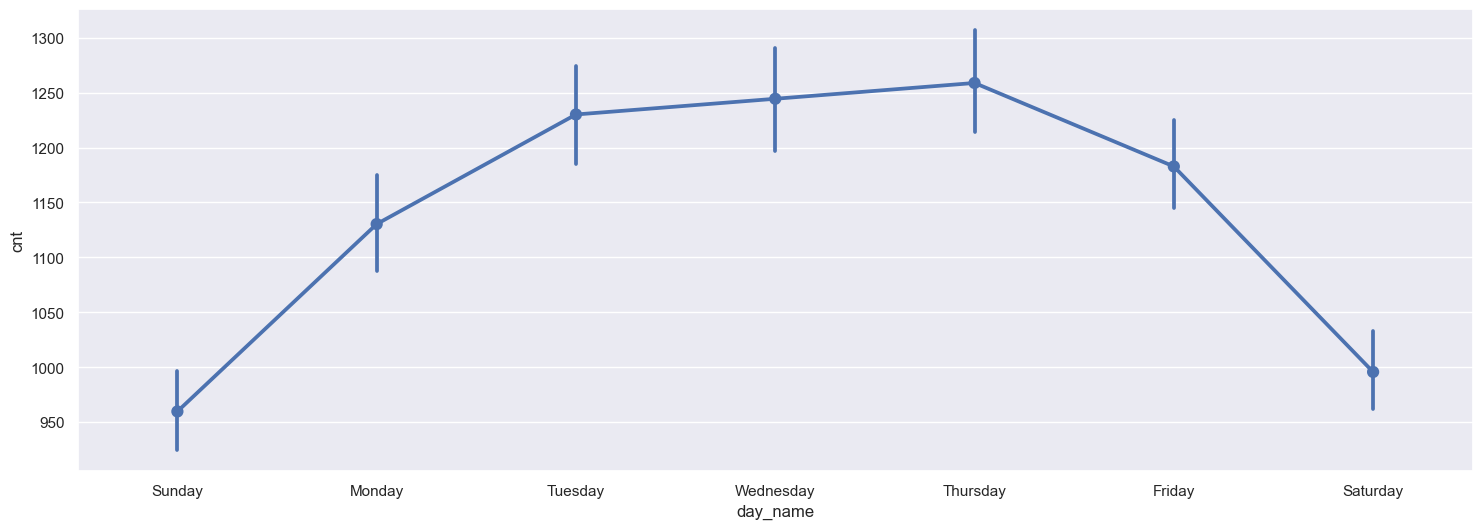

In [327]:
sns.pointplot(x='day_name', y='cnt', data=london)

In [328]:
# Проверим распределения аренд по дням недели на нормальность 
pg.normality(data=london, dv='cnt', group='day_name', method='normaltest')

,W,pval,normal
day_name,,,
Sunday,443.252761,5.609006e-97,False
Monday,521.445947,5.881003e-114,False
Tuesday,500.394797,2.191040e-109,False
Wednesday,488.469600,8.514791e-107,False
Thursday,593.716618,1.191447e-129,False
Friday,362.218294,2.214608e-79,False
Saturday,390.922308,1.295088e-85,False


In [329]:
# Поскольку распределения отличаются от нормальных, используем непараметрический аналог ANOVA критерий Краскела-Уоллиса
pg.kruskal(data=london, dv='cnt', between='day_name')

,Source,ddof1,H,p-unc
Kruskal,day_name,6,105.972725,1.419065e-20


In [330]:
# Как минимум в двух группах обнаружены статистически значимые различия
# Проверяем в каких именно группах
sp.posthoc_dunn(a=london, val_col='cnt', group_col='day_name', p_adjust='holm')

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
Friday,1.000000e+00,0.001374,2.309443e-06,6.677033e-12,1.000000e+00,1.000000e+00,1.000000e+00
Monday,1.374358e-03,1.000000,1.000000e+00,5.736639e-03,5.367728e-04,5.999481e-02,3.909912e-03
Saturday,2.309443e-06,1.000000,1.000000e+00,3.619557e-01,6.202471e-07,5.127158e-04,9.541156e-06
Sunday,6.677033e-12,0.005737,3.619557e-01,1.000000e+00,1.008553e-12,1.351319e-08,4.616781e-11
Thursday,1.000000e+00,0.000537,6.202471e-07,1.008553e-12,1.000000e+00,1.000000e+00,1.000000e+00
Tuesday,1.000000e+00,0.059995,5.127158e-04,1.351319e-08,1.000000e+00,1.000000e+00,1.000000e+00
Wednesday,1.000000e+00,0.003910,9.541156e-06,4.616781e-11,1.000000e+00,1.000000e+00,1.000000e+00


1. Статистически значимые различия обнаружены между понедельником и средой, четвергом, пятницой.
2. Между вторником, средой, четвергом и пятницой различий не обнаружено.
3. Между выходными днями (субботой и воскресеньем) различий не обнаружено.
4. Обнаружены различия между выходными и рабочими днями.
5. Обнаружены различия между понедельником и пятницой.
6. Если сравнивать между собой рабочие дни, то больше всего по количеству аренд отличается понедельник.
7. Для увеличения размера прибыли с аренды велосипедов в понедельник и выходные можно организовать дни скидок и акций.

### Регрессионная модель

In [331]:
# Прежде чем строить регрессионную модель, нужно посмотреть на корреляцию между предикторами.
london.corr()

,cnt,t1,t2,hum,wind_speed
cnt,1.000000,0.388798,0.369035,-0.462901,0.116295
t1,0.388798,1.000000,0.988344,-0.447781,0.145471
t2,0.369035,0.988344,1.000000,-0.403495,0.088409
hum,-0.462901,-0.447781,-0.403495,1.000000,-0.287789
wind_speed,0.116295,0.145471,0.088409,-0.287789,1.000000


In [332]:
# Между t1 (температура) и t2 (температура как ощущается) сильная положительная корреляция.
# Чтобы избежать мультиколлинеарность, нужно исключить из модели t1 или t2.

In [333]:
# Построим регрессионную модель c учётом тепературы, влажности и скорости ветра.
y = london['cnt']
x =  london[['t1', 'hum', 'wind_speed']]
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     1996.
Date:                Tue, 04 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:03:11   Log-Likelihood:            -1.4385e+05
No. Observations:               17414   AIC:                         2.877e+05
Df Residuals:                   17410   BIC:                         2.877e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2655.1744     56.882     46.678      0.0

Полученная модель объясняет 26% изменчивости зависимой переменной (число аренд).
По полученной регрессионной модели можно заключить следующее:
 1. При возрастании температуры на 1C число аренд увеличивается на 44.
 2. При увеличении влажности на 1% число аренд сокращается на 27.
 3. При увеличении скорости ветра на 1 км/ч число аренд падает на 3.

In [371]:
# Построим регрессионную модель c учётом тепературы (как ощущается), влажности и скорости ветра.
y_1 = london['cnt']
x_1 =  london[['t2', 'hum', 'wind_speed']]
x_1 = sm.add_constant(x_1)
model_1 = sm.OLS(y_1, x_1).fit()
print(model_1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     1977.
Date:                Tue, 04 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:56:38   Log-Likelihood:            -1.4387e+05
No. Observations:               17414   AIC:                         2.877e+05
Df Residuals:                   17410   BIC:                         2.878e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2834.5394     53.956     52.534      0.0

Разница между Adj. R-squared t1 и t2 составляет менее 1%. Оставим в модели t1.
Построим несколько меделей: со всеми предикторами, с учётом сезонности, дней недели, выходных и празничных дней, погодных условий.

In [335]:
# Построим модель со всеми предикторами.
# Для этого создадим фиктивные переменные.
london_dummy = pd.get_dummies(data=london, drop_first=True)

In [336]:
london_dummy.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code_небольшой дождь,weather_code_облачно,weather_code_пасмурно,weather_code_преимущественно ясно,...,is_weekend_workday,season_spring,season_summer,season_winter,day_name_Monday,day_name_Saturday,day_name_Sunday,day_name_Thursday,day_name_Tuesday,day_name_Wednesday
timestamp,,,,,,,,,,,,,,,,,,,,,
2015-01-04 00:00:00,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
2015-01-04 01:00:00,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2015-01-04 02:00:00,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2015-01-04 03:00:00,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2015-01-04 04:00:00,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0


In [372]:
# Погодные условия
weather = london_dummy.columns[london_dummy.columns.str.startswith('weather')].to_list()

In [373]:
# Сезоны
season = london_dummy.columns[london_dummy.columns.str.startswith('season')].to_list()

In [374]:
# Дни недели
day_name = london_dummy.columns[london_dummy.columns.str.startswith('day_name')].to_list()

In [375]:
# Температура, влажность и скорость ветра
temp = ['t1', 'hum', 'wind_speed']

In [376]:
# Праздничные и выходные дни
day = ['is_holiday_not holiday', 'is_weekend_workday']

In [377]:
# Модель со всеми предикторами
y_all = london_dummy['cnt']
x_all = london_dummy[weather + season + day_name + day + temp]
x_all = sm.add_constant(x_all)
model_all = sm.OLS(y_all, x_all).fit()
print(model_all.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     373.5
Date:                Tue, 04 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:57:21   Log-Likelihood:            -1.4344e+05
No. Observations:               17414   AIC:                         2.869e+05
Df Residuals:                   17394   BIC:                         2.871e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

R-squared увеличился на 3%.
29% изменчивости объясняется полученной моделью. А 71% изменчивости зависит от других факторов.

In [344]:
# Посмотрим как включение отдельных предикторов повлияет на качество модели.
# С учётом выходных и праздничных дней.
y_holiday = london_dummy['cnt']
x_holiday = london_dummy[temp + day]
x_holiday = sm.add_constant(x_holiday)
model_holiday = sm.OLS(y_holiday, x_holiday).fit()
print(model_holiday.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     1253.
Date:                Tue, 04 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:03:12   Log-Likelihood:            -1.4375e+05
No. Observations:               17414   AIC:                         2.875e+05
Df Residuals:                   17408   BIC:                         2.876e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   2196

In [345]:
# С учётом дней недели.
y_day = london_dummy['cnt']
x_day = london_dummy[temp + day]
x_day = sm.add_constant(x_day)
model_day = sm.OLS(y_day, x_day).fit()
print(model_day.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     1253.
Date:                Tue, 04 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:03:12   Log-Likelihood:            -1.4375e+05
No. Observations:               17414   AIC:                         2.875e+05
Df Residuals:                   17408   BIC:                         2.876e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   2196

In [346]:
# С учётом сезонов.
y_season = london_dummy['cnt']
x_season = london_dummy[temp + season]
x_season = sm.add_constant(x_season)
model_season = sm.OLS(y_season, x_season).fit()
print(model_season.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     1037.
Date:                Tue, 04 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:03:12   Log-Likelihood:            -1.4376e+05
No. Observations:               17414   AIC:                         2.875e+05
Df Residuals:                   17407   BIC:                         2.876e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2738.8134     64.670     42.351

In [347]:
# С учётом погоды.
y_weather = london_dummy['cnt']
x_weather = london_dummy[temp + weather]
x_weather = sm.add_constant(x_weather)
model_weather = sm.OLS(y_weather, x_weather).fit()
print(model_weather.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     737.2
Date:                Tue, 04 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:03:12   Log-Likelihood:            -1.4361e+05
No. Observations:               17414   AIC:                         2.872e+05
Df Residuals:                   17404   BIC:                         2.873e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

Модель с выходными/праздниками/сезонами/днями недели объясняет 26% изменчивости числа аренд. 
Включение в модель погодных условий позволяет объяснить 28% изменчивости зависимой переменной.

Общие выводы:
   1. В полученных данных выявлены скачки числа аренд. Чтобы определить дни с аномальными данными, построен доверительный интервал для скользящего среднего. Самое высокое значение числа аренд было 09.07.2015, что связано с забастовками работников метро. Самое низкое число аренд 02.09.2015 связано с ошибкой внесения данных.
   2. Проведён ANOVA числа аренд по дням недели с использованием непараметрического критерия Краскела-Уоллиса. Если сравнивать между собой рабочие дни, то больше всего статистически значимых различий выявлено между понедельником и остальными рабочими днями. Также обнаружены статистически значимые различия между выходными и рабочими днями. В то время как между субботой и воскресеньем значимых различий не найдено. Для увеличения размера прибыли с аренды велосипедлв в понедельник и выходные можно организовать дни скидок и акций.
   3. Построены регрессионные модели с разными предикторами. 
По результатам:
   1. 25% изменчивости числа аренд объясняется моделью с учётом тепературы, влажности и скорости ветра; 
   2. 26% изменчивости объясняется моделью с учётом тепературы, влажности, скорости ветра и сезонов/празников/выходных/дней недели; 
   3. 28% изменчивости числа аренд объясняется моделью с учётом тепературы, влажности, скорости ветра и погодных условий (ясно, облачно, дождь и т.д.); 
   4. 29% изменчивости числа аренд объясняется моделью с всеми предикторами. 
   5. Даже самая лучшая модель объясняет только 29% изменчивости зависимой переменной, 71% зависит от других факторов. Предоставленных данных недостаточно, чтобы в полной мере объяснить изменение числа аренд.